Authors: Łukasz Reinke <s15037@pjwstk.edu.pl>, Konrad Chrzanowski <s17404@pjwstk.edu.pl>

Problem: Train AI to play bowling game

Followed by: github user @deepanshut041

# install os dependencies to display env

In [2]:
!apt-get install python-opengl -y

!apt install xvfb -y

!pip install pyvirtualdisplay

!pip install piglet


Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


# Import python dependencies

In [3]:
import time
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf
import math

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


# start virtual display

In [4]:
from pyvirtualdisplay import Display
Display().start()


#import ai classes

In [5]:
import sys
from agent import A2CAgent
from models import ActorCnn, CriticCnn
from stack_frame import preprocess_frame, stack_frame

# create environment

In [19]:
%pip install -U gym>=0.21.0
%pip install -U gym[atari,accept-rom-license]
env = gym.make('Bowling-v0')
env.seed(0)

(0, 592379725)

# set accelerator 

In [20]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


# view Enviroment

The size of frame is:  (210, 160, 3)
No. of Actions:  6


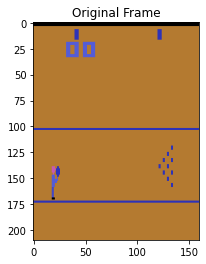

In [21]:
print("The size of frame is: ", env.observation_space.shape)
print("No. of Actions: ", env.action_space.n)
env.reset()
plt.figure()
plt.imshow(env.reset())
plt.title('Original Frame')
plt.show()

### execute the code cell below to play with a random policy.

In [22]:
def random_play():
    score = 0
    env.reset()
    while True:
        env.render()
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        score += reward
        if done:
            env.close()
            print("Your Score at end of game is: ", score)
            break
random_play()

/usr/local/lib/python3.7/dist-packages/gym/envs/atari/environment.py:257: UserWarning: WARN: We strongly suggest supplying `render_mode` when constructing your environment, e.g., gym.make(ID, render_mode='human'). Using `render_mode` provides access to proper scaling, audio support, and proper framerates.
  "We strongly suggest supplying `render_mode` when "


Your Score at end of game is:  18.0




```
# Sformatowano jako kod
```

# preprocessing frame

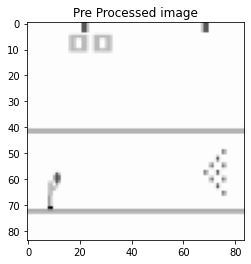

In [23]:
env.reset()
plt.figure()
plt.imshow(preprocess_frame(env.reset(), (8, -12, -12, 4), 84), cmap="gray")
plt.title('Pre Processed image')
plt.show()

# stacking frame

In [24]:
def stack_frames(frames, state, is_new=False):
    frame = preprocess_frame(state, (8, -12, -12, 4), 84)
    frames = stack_frame(frames, frame, is_new)

    return frames
    

# creating agent

In [25]:
INPUT_SHAPE = (4, 84, 84)
ACTION_SIZE = env.action_space.n
SEED = 0
GAMMA = 0.99           # discount factor
ALPHA= 0.0001          # Actor learning rate
BETA = 0.0005          # Critic learning rate
UPDATE_EVERY = 100     # how often to update the network 

agent = A2CAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, GAMMA, ALPHA, BETA, UPDATE_EVERY, ActorCnn, CriticCnn)

# run untrained agent play

In [26]:

state = stack_frames(None, env.reset(), True) 
for j in range(200):
    env.render()
    action, _, _ = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    state = stack_frames(state, next_state, False)
    if done:
        break 
        
env.close()

/usr/local/lib/python3.7/dist-packages/gym/envs/atari/environment.py:257: UserWarning: WARN: We strongly suggest supplying `render_mode` when constructing your environment, e.g., gym.make(ID, render_mode='human'). Using `render_mode` provides access to proper scaling, audio support, and proper framerates.
  "We strongly suggest supplying `render_mode` when "


# loading agent
Uncomment line to load a pretrained agent

In [27]:
start_epoch = 0
scores = []
scores_window = deque(maxlen=20)

# train the agent with DQN

In [28]:
def train(n_episodes=1000):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    for i_episode in range(start_epoch + 1, n_episodes+1):
        state = stack_frames(None, env.reset(), True)
        score = 0
        while True:
            action, log_prob, entropy = agent.act(state)
            next_state, reward, done, info = env.step(action)
            score += reward
            next_state = stack_frames(state, next_state, False)
            agent.step(state, log_prob, entropy, reward, done, next_state)
            state = next_state
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        
        clear_output(True)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(scores)), scores)
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.show()
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    
    return scores

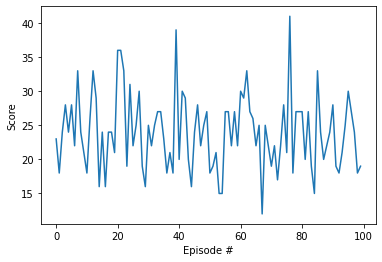

Episode 100	Average Score: 23.00

In [29]:
scores = train(100)

# run learnt agent

In [30]:
score = 0
state = stack_frames(None, env.reset(), True)
while True:
    env.render()
    action, _, _ = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    score += reward
    state = stack_frames(state, next_state, False)
    if done:
        print("You Final score is:", score)
        break 
env.close()

/usr/local/lib/python3.7/dist-packages/gym/envs/atari/environment.py:257: UserWarning: WARN: We strongly suggest supplying `render_mode` when constructing your environment, e.g., gym.make(ID, render_mode='human'). Using `render_mode` provides access to proper scaling, audio support, and proper framerates.
  "We strongly suggest supplying `render_mode` when "


You Final score is: 25.0
